# Simple Visualizations - Results from Run Notebooks

Just plotting results from the different run files

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mlmc_functions import run_mlmc, mu_S, sigma_S
from unbiased_mc_functions import mu_X, run_unbiased_mc, run_unbiased_asian_mc, compute_gamma

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Setup parameters
T = 1.0
K = 1.0
M_param = 4.0
sigma_matrix = 0.5 * np.identity(1)
mu_max = 5
gamma = compute_gamma(sigma_matrix, mu_max, 1, T)
beta = 0.15

## MLMC European Option - Different Epsilon Values

In [44]:
# Run MLMC with different epsilon to see convergence
import time

epsilon_list = [0.003, 0.001,0.0003,0.0001]
mlmc_results = []

for eps in epsilon_list:
    start_time = time.time()
    result = run_mlmc(
        mu_func=mu_S,
        sigma_func=sigma_S,
        T=1.0,
        K=1.0,
        M_param=4.0,
        epsilon=eps,
        max_levels=10,
        N_initial=10000,
        verbose=True
    )
    elapsed_time = time.time() - start_time
    result['time'] = elapsed_time
    mlmc_results.append(result)
    print(f"Epsilon {eps}: Estimate = {result['estimate']:.6f}, Levels = {result['levels']}, Time = {elapsed_time:.2f}s")

MULTILEVEL MONTE CARLO - EUROPEAN OPTION

LEVEL L = 0
Step 2: Initial sampling (N=10000, M=1)
  E[P_0] = 0.200806, Var[P_0] = 0.083519

Step 3: Optimal sample allocation
  Level 0: N_opt = 18,560 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +8,560 samples

LEVEL L = 1
Step 2: Initial sampling (N=10000, M_c=1, M_f=4)
  E[P_1 - P_0] = 0.007374, Var = 0.013541

Step 3: Optimal sample allocation
  Level 0: N_opt = 33,507 (current = 18,560)
  Level 1: N_opt = 6,746 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +14,947 samples

LEVEL L = 2
Step 2: Initial sampling (N=10000, M_c=4, M_f=16)
  E[P_2 - P_1] = 0.000149, Var = 0.005839

Step 3: Optimal sample allocation
  Level 0: N_opt = 53,136 (current = 33,507)
  Level 1: N_opt = 10,698 (current = 10,000)
  Level 2: N_opt = 3,513 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +19,629 samples
  Level 1: +698 samples

Step 5: Convergence test (Equation 10)
  Max(|Y_1|/M, |Y_2|) = 1.814068e-03
  Threshold 

KeyboardInterrupt: 

## Unbiased MC European Option - Different Sample Sizes

In [34]:
# Test Unbiased MC with different sample sizes
N_list = [50000, 100000, 500000, 1000000, 5000000, 10000000]
unbiased_results = []

for N in N_list:
    np.random.seed(42)
    
    start_time = time.time()
    # Run unbiased MC
    X_T, X_T_NT, N_T, weights = run_unbiased_mc(
        N_mc=N,
        X_0=0.0,
        beta=beta,
        mu_func=mu_X,
        sigma_0=0.5,
        M=M_param,
        T=T
    )
    
    # Compute European call payoff
    g_X_T = np.maximum(np.exp(X_T) - K, 0)
    g_X_T_NT = np.maximum(np.exp(X_T_NT) - K, 0)
    indicator = (N_T > 0).astype(float)
    payoff = weights * (g_X_T - g_X_T_NT * indicator)
    
    estimate = np.mean(payoff)
    std_error = np.std(payoff) / np.sqrt(len(payoff))
    elapsed_time = time.time() - start_time
    
    unbiased_results.append({'estimate': estimate, 'std_error': std_error, 'time': elapsed_time})
    print(f"N={N}: Est={estimate:.6f} ± {std_error:.6f}, Time={elapsed_time:.2f}s")

c:\Users\jacqu\MonteCarlo\unbiased_mc_functions.py:159: RuntimeWarning: invalid value encountered in divide
  w = (mu_k - mu_prev) * dW_matrix[:, k] / (sigma_0 * dt_matrix[:, k])


N=50000: Est=0.205005 ± 0.001998, Time=0.07s
N=100000: Est=0.205574 ± 0.001548, Time=0.09s
N=500000: Est=0.205268 ± 0.000640, Time=0.45s
N=1000000: Est=0.206018 ± 0.000454, Time=1.02s
N=5000000: Est=0.205672 ± 0.000202, Time=5.25s
N=10000000: Est=0.205613 ± 0.000143, Time=14.34s


## Plot Results

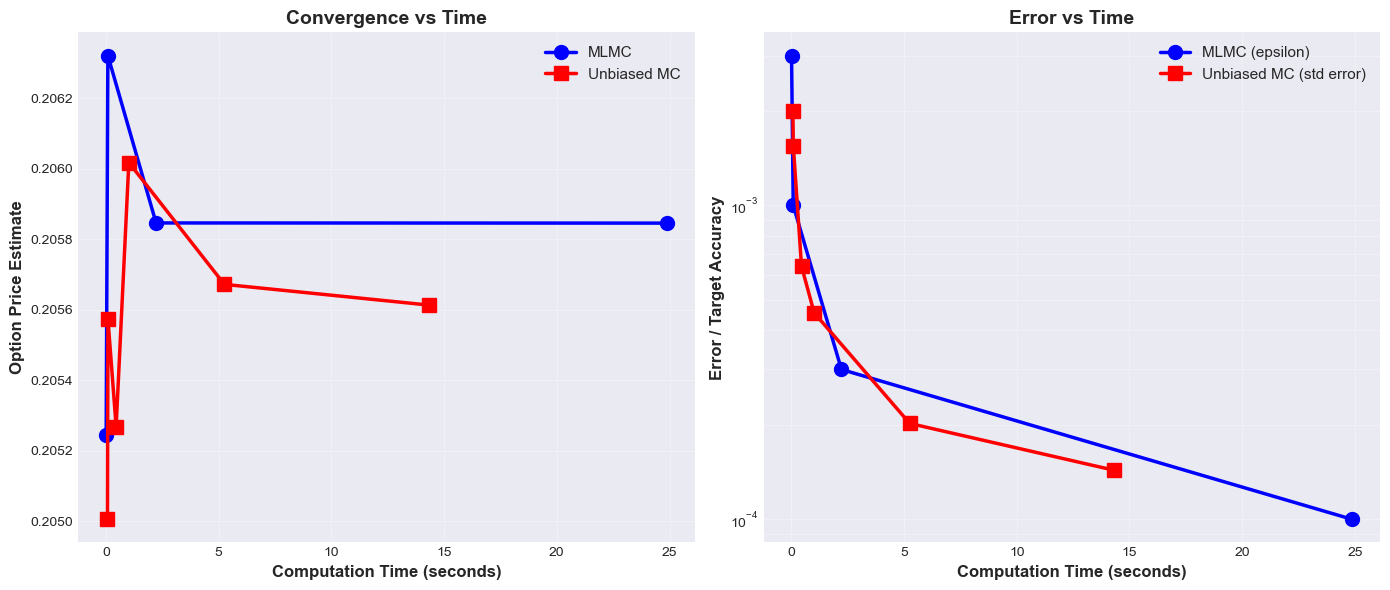

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Estimate vs Time
mlmc_times = [r['time'] for r in mlmc_results]
mlmc_ests = [r['estimate'] for r in mlmc_results]
unb_times = [r['time'] for r in unbiased_results]
unb_ests = [r['estimate'] for r in unbiased_results]

ax1.plot(mlmc_times, mlmc_ests, 'o-', linewidth=2.5, markersize=10, label='MLMC', color='blue')
ax1.plot(unb_times, unb_ests, 's-', linewidth=2.5, markersize=10, label='Unbiased MC', color='red')
ax1.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Option Price Estimate', fontsize=12, fontweight='bold')
ax1.set_title('Convergence vs Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: Error vs Time (epsilon for MLMC, std_error for Unbiased MC)
mlmc_epsilons = epsilon_list  # Target accuracy (epsilon)
unb_errs = [r['std_error'] for r in unbiased_results]

ax2.semilogy(mlmc_times, mlmc_epsilons, 'o-', linewidth=2.5, markersize=10, label='MLMC (epsilon)', color='blue')
ax2.semilogy(unb_times, unb_errs, 's-', linewidth=2.5, markersize=10, label='Unbiased MC (std error)', color='red')
ax2.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Error / Target Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Error vs Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

## Summary

In [36]:
print("\n" + "="*80)
print("MLMC RESULTS")
print("="*80)
print(f"{'Epsilon':<12} {'Estimate':<12} {'Levels':<10} {'Samples':<15} {'Time (s)':<10}")
print("-"*80)
for i, eps in enumerate(epsilon_list):
    r = mlmc_results[i]
    print(f"{eps:<12.4f} {r['estimate']:<12.6f} {r['levels']:<10} {r['total_samples']:<15,} {r['time']:<10.2f}")

print("\n" + "="*80)
print("UNBIASED MC RESULTS")
print("="*80)
print(f"{'N Samples':<15} {'Estimate':<15} {'Std Error':<12} {'Time (s)':<10}")
print("-"*80)
for i, N in enumerate(N_list):
    r = unbiased_results[i]
    print(f"{N:<15,} {r['estimate']:<15.6f} {r['std_error']:<12.6f} {r['time']:<10.2f}")

print("="*80)


MLMC RESULTS
Epsilon      Estimate     Levels     Samples         Time (s)  
--------------------------------------------------------------------------------
0.0030       0.205244     3          76,572          0.01      
0.0010       0.206322     4          840,259         0.09      
0.0003       0.205846     5          12,552,378      2.22      
0.0001       0.205846     5          112,589,238     24.87     

UNBIASED MC RESULTS
N Samples       Estimate        Std Error    Time (s)  
--------------------------------------------------------------------------------
50,000          0.205005        0.001998     0.07      
100,000         0.205574        0.001548     0.09      
500,000         0.205268        0.000640     0.45      
1,000,000       0.206018        0.000454     1.02      
5,000,000       0.205672        0.000202     5.25      
10,000,000      0.205613        0.000143     14.34     


## Asian Option - MLMC

In [38]:
# Run MLMC for Asian option with different epsilon
epsilon_list_asian = [0.003, 0.001,0.0003,0.0001]
mlmc_asian_results = []

for eps in epsilon_list_asian:
    start_time = time.time()
    result = run_mlmc(
        mu_func=mu_S,
        sigma_func=sigma_S,
        T=1.0,
        K=1.0,
        M_param=4.0,
        epsilon=eps,
        max_levels=8,
        N_initial=10000,
        n_asian=10,  # Asian option with 10 timesteps
        M_base=10,
        verbose=True
    )
    elapsed_time = time.time() - start_time
    result['time'] = elapsed_time
    mlmc_asian_results.append(result)
    print(f"Epsilon {eps}: Estimate = {result['estimate']:.6f}, Levels = {result['levels']}, Time = {elapsed_time:.2f}s")

MULTILEVEL MONTE CARLO - ASIAN OPTION (n_asian=10)

LEVEL L = 0
Step 2: Initial sampling (N=10000, M=10)
  E[P_0] = 0.127680, Var[P_0] = 0.050160

Step 3: Optimal sample allocation
  Level 0: N_opt = 11,147 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +1,147 samples

LEVEL L = 1
Step 2: Initial sampling (N=10000, M_c=10, M_f=40)
  E[P_1 - P_0] = 0.000029, Var = 0.000745

Step 3: Optimal sample allocation
  Level 0: N_opt = 13,863 (current = 11,147)
  Level 1: N_opt = 845 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +2,716 samples

LEVEL L = 2
Step 2: Initial sampling (N=10000, M_c=40, M_f=160)
  E[P_2 - P_1] = 0.000095, Var = 0.000200

Step 3: Optimal sample allocation
  Level 0: N_opt = 16,681 (current = 13,863)
  Level 1: N_opt = 1,017 (current = 10,000)
  Level 2: N_opt = 264 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +2,818 samples

Step 5: Convergence test (Equation 10)
  Max(|Y_1|/M, |Y_2|) = 9.494516e-05
  Threshold = 6.363961e-03
 

## Asian Option - Unbiased MC

In [ ]:
# Test Unbiased MC for Asian option with different sample sizes
N_list_asian = [50000, 100000, 500000, 1000000, 5000000]
unbiased_asian_results = []

for N in N_list_asian:
    np.random.seed(42)
    
    start_time = time.time()
    # Run unbiased MC for Asian option
    X_paths, X_zero_paths, psi_estimate = run_unbiased_asian_mc(
        N_mc=N,
        X_0=0.0,
        beta=beta,
        mu_func=mu_X,
        sigma_0=0.5,
        M=M_param,
        n_timesteps=10,
        T=T
    )
    
    estimate = np.mean(psi_estimate)
    std_error = np.std(psi_estimate) / np.sqrt(len(psi_estimate))
    elapsed_time = time.time() - start_time
    
    unbiased_asian_results.append({'estimate': estimate, 'std_error': std_error, 'time': elapsed_time})
    print(f"N={N}: Est={estimate:.6f} ± {std_error:.6f}, Time={elapsed_time:.2f}s")

c:\Users\jacqu\MonteCarlo\unbiased_mc_functions.py:245: RuntimeWarning: invalid value encountered in divide
  w = (mu_j - mu_prev) * dW_mat[:, j] / (sigma_0 * dt_mat[:, j])


N=50000: Est=0.126630 ± 0.001162, Time=0.40s
N=100000: Est=0.126098 ± 0.000816, Time=0.77s
N=500000: Est=0.126331 ± 0.000363, Time=4.42s
N=1000000: Est=0.126338 ± 0.000257, Time=8.87s
N=5000000: Est=0.126147 ± 0.000115, Time=58.57s


KeyboardInterrupt: 

## Asian Option - Plots

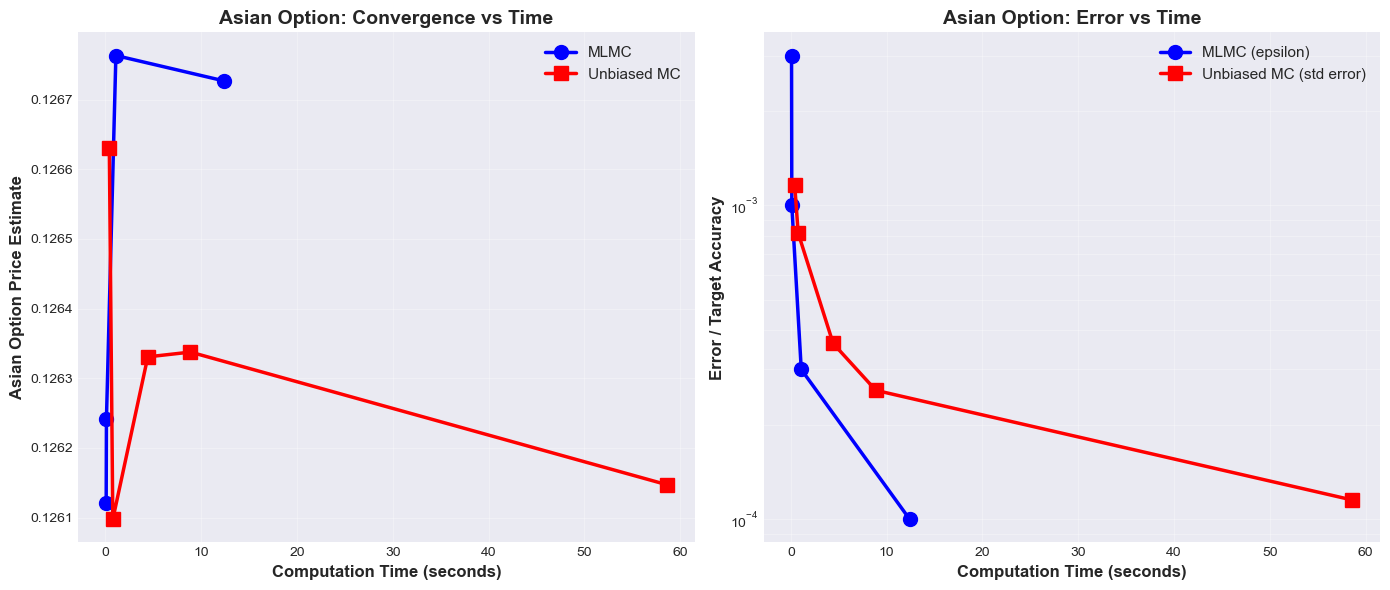

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Estimate vs Time for Asian option
mlmc_asian_times = [r['time'] for r in mlmc_asian_results]
mlmc_asian_ests = [r['estimate'] for r in mlmc_asian_results]
unb_asian_times = [r['time'] for r in unbiased_asian_results]
unb_asian_ests = [r['estimate'] for r in unbiased_asian_results]

ax1.plot(mlmc_asian_times, mlmc_asian_ests, 'o-', linewidth=2.5, markersize=10, label='MLMC', color='blue')
ax1.plot(unb_asian_times, unb_asian_ests, 's-', linewidth=2.5, markersize=10, label='Unbiased MC', color='red')
ax1.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Asian Option Price Estimate', fontsize=12, fontweight='bold')
ax1.set_title('Asian Option: Convergence vs Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: Error vs Time for Asian option
mlmc_asian_epsilons = epsilon_list_asian
unb_asian_errs = [r['std_error'] for r in unbiased_asian_results]

ax2.semilogy(mlmc_asian_times, mlmc_asian_epsilons, 'o-', linewidth=2.5, markersize=10, label='MLMC (epsilon)', color='blue')
ax2.semilogy(unb_asian_times, unb_asian_errs, 's-', linewidth=2.5, markersize=10, label='Unbiased MC (std error)', color='red')
ax2.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Error / Target Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Asian Option: Error vs Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

## Asian Option - Summary

In [42]:
print("\n" + "="*80)
print("ASIAN OPTION - MLMC RESULTS")
print("="*80)
print(f"{'Epsilon':<12} {'Estimate':<12} {'Levels':<10} {'Samples':<15} {'Time (s)':<10}")
print("-"*80)
for i, eps in enumerate(epsilon_list_asian):
    r = mlmc_asian_results[i]
    print(f"{eps:<12.4f} {r['estimate']:<12.6f} {r['levels']:<10} {r['total_samples']:<15,} {r['time']:<10.2f}")

print("\n" + "="*80)
print("ASIAN OPTION - UNBIASED MC RESULTS")
print("="*80)
print(f"{'N Samples':<15} {'Estimate':<15} {'Std Error':<12} {'Time (s)':<10}")
print("-"*80)
for i, N in enumerate(N_list_asian):
    r = unbiased_asian_results[i]
    print(f"{N:<15,} {r['estimate']:<15.6f} {r['std_error']:<12.6f} {r['time']:<10.2f}")

print("="*80)


ASIAN OPTION - MLMC RESULTS
Epsilon      Estimate     Levels     Samples         Time (s)  
--------------------------------------------------------------------------------
0.0030       0.126122     3          36,681          0.07      
0.0010       0.126241     3          170,638         0.10      
0.0003       0.126763     3          1,740,642       1.09      
0.0001       0.126727     3          16,190,427      12.41     

ASIAN OPTION - UNBIASED MC RESULTS
N Samples       Estimate        Std Error    Time (s)  
--------------------------------------------------------------------------------
50,000          0.126630        0.001162     0.40      
100,000         0.126098        0.000816     0.77      
500,000         0.126331        0.000363     4.42      
1,000,000       0.126338        0.000257     8.87      
5,000,000       0.126147        0.000115     58.57     


IndexError: list index out of range